Business Understanding

In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Data Understaning

In [1]:
from genres import collect_genre_features

In [2]:
genre_playlists = {
    'bluegrass':'https://www.youtube.com/playlist?list=PLKUA473MWUv2mddNMPh-MJkgTR5AjTpl3',
    'blues':'https://www.youtube.com/playlist?list=PLxvodScTx2RuB7Yh_d21kD0HDZvDXWBbY',
    'folk':'https://www.youtube.com/playlist?list=PLGBuKfnErZlBLNzS_JlDAeiH5aW26rvHc',
    'classic_rock':'https://www.youtube.com/playlist?list=PLNxOe-buLm6cz8UQ-hyG1nm3RTNBUBv3K'
}
# collect_genre_features(genre_playlists, data_fp='data/extra_genre_features.json')

In [3]:
import pandas as pd

In [4]:
df_extra = pd.read_json('data/extra_genre_features.json', lines=True)

In [5]:
df_extra.groupby('genre').song.nunique()

genre
bluegrass       87
blues           92
classic_rock    80
folk            74
Name: song, dtype: int64

In [6]:
df_extra.groupby('genre').song.count()

genre
bluegrass       2083
blues           2206
classic_rock    1920
folk            1773
Name: song, dtype: int64

Not perfect but a reasonable chunk.

### Lets Pickle them for storage on git.

In [7]:
import pickle

In [8]:
with open('data/extra_genre_features.pkl', 'wb') as f:
    pickle.dump(df_extra.to_json(), f)

In [9]:
df_original = pd.read_json('data/genre_features.json', lines=True)

In [10]:
with open('data/genre_features.pkl', 'wb') as f:
    pickle.dump(df_original.to_json(), f)

### Data Preparation

Putting the old with the new.

In [11]:
with open('data/genre_features.pkl', 'rb') as f:
    df_original = pd.read_json(pickle.load(f))
with open('data/extra_genre_features.pkl', 'rb') as f:
    df_extra = pd.read_json(pickle.load(f))

In [19]:
df = pd.concat([df_original, df_extra])

In [23]:
from sklearn.model_selection import train_test_split

y = df['genre']
X = df.drop(['genre', 'song'], axis=1)
X_model, X_val, y_model, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=111,
    stratify=y
)
X_train, X_test, y_train, y_test = train_test_split(
    X_model,
    y_model,
    test_size=0.2,
    random_state=111,
    stratify=y_model
)

In [24]:
y.value_counts()

metal           2399
jazz            2397
country         2389
electronic      2371
hip_hop         2345
classical       2320
blues           2206
bluegrass       2083
classic_rock    1920
folk            1773
Name: genre, dtype: int64

In [36]:
tt_split_dists = pd.concat(
    [
        y_train.value_counts(sort=False),
        y_test.value_counts(sort=False),
        y_val.value_counts(sort=False)
    ],
    axis=1,
    sort=False
)
tt_split_dists

,genre,genre,genre
bluegrass,1333,333,417
metal,1535,384,480
hip_hop,1501,375,469
classical,1485,371,464
electronic,1517,380,474
jazz,1534,384,479
classic_rock,1229,307,384
country,1529,382,478
folk,1134,284,355
blues,1412,353,441


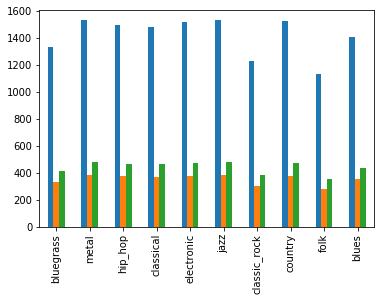

In [42]:
tt_split_dists.plot.bar(legend=False);

Displots for genres - x x - x - x x- x- x- x

### Modeling

First run to compare with prior best performer

In [63]:
labels = list(df.genre.unique())

In [79]:
from sklearn.preprocessing import PowerTransformer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from genres import eval_model
svc_model = SVC(
    C=10,
    gamma=0.25,
    probability=True,
)
svc = Pipeline([
    ('scaling', PowerTransformer()),
    ('model', svc_model)
])
svc.fit(X_train, y_train)
pred_probas = svc.predict_proba(X_test)
preds = svc.predict(X_test)
eval_model(y_test, preds, pred_probas, labels)


    Log Loss:
        0.5421016940954572
    Jaccard:
        0.72228
	-Country: 0.6179)
	-Jazz: 0.8381)
	-Hip_Hop: 0.64871)
	-Classical: 0.78231)
	-Metal: 0.73288)
	-Electronic: 0.63736)
	-Bluegrass: 0.81148)
	-Blues: 0.70892)
	-Folk: 0.73292)
	-Classic_Rock: 0.71221)


And what about it's competitor?

In [81]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA

In [83]:
gbt_model = GradientBoostingClassifier(
    max_depth=6,
    n_estimators=200,
    subsample=0.8,
)
gbt = Pipeline([
    ('PCA', PCA()),
    ('model', gbt_model)
])
gbt.fit(X_train, y_train)
pred_probas = gbt.predict_proba(X_test)
preds = gbt.predict(X_test)
eval_model(y_test, preds, pred_probas, labels)


    Log Loss:
        0.7208098997431877
    Jaccard:
        0.62457
	-Country: 0.5165)
	-Jazz: 0.74728)
	-Hip_Hop: 0.6179)
	-Classical: 0.72687)
	-Metal: 0.62389)
	-Electronic: 0.58898)
	-Bluegrass: 0.71247)
	-Blues: 0.58315)
	-Folk: 0.58651)
	-Classic_Rock: 0.54211)


It still appears that Support Vectors are outperforming the tree models.

#### Fine Tuning

In [84]:
from sklearn.model_selection import GridSearchCV

Evaluation

Deployment